In [3]:
%load_ext autoreload
%autoreload 2

from dataclasses import dataclass
from typing import Callable
import numpy.typing as npt

import numpy as np
import cvxpy as cp
from typing import Any
import numpy as np
# from throughput import read_graph_data, read_traffic_mat, solve_problem_with_flow
from pathlib import Path
import cvxpy as cp
import matplotlib.pyplot as plt

from paper_code.altorithm import gamma_for_budget
from paper_code.multicommodity_flow.process_graph import read_graph, read_traffic, solve_problem_with_flow
from paper_code.multicommodity_flow.graph_functions import GraphFunc
from paper_code.utils.drawer import get_fig_set_style

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from copy import deepcopy

p = Path('../datasets/germany50')

gr = read_graph(p)
b_max = gr['bandwidth']

# m сценариев, n -  размерность пространства поиска
m = 3
n = len(b_max)

# для эксперимента нужно определить стоимости аренды
# пропускных способностей с_a и c_b

gr['cost'] /= 1000
cost = gr['cost']  # стоимость обслуживания единицы пропускной способности
begin_cost = ((1/cost)**0.5) * 10 * (0.9 + np.random.rand(n) * 0.2)
additional_cost = begin_cost * (1.05 + np.random.rand(n) * 0.1)

# далее инициализируем параметры функций и посчитаем их в полученных точках


параметры для экспериментов генерировались так стоимости потоков есть в самом датасете. На их основе генерировались начальная стоимость аренды и стоимость внутри периода. Если пропускная способность стоит дешевле, то это более качественная пропускная полоса, поэтому стоимость такой полосы должна быть выше. Также считаем аренду дороже, чем обслуживание. Поэтому стоимости в начале периода генерировались как $(c_b)_i = (1/flow_cost) \xi$, где $\xi \sim U[9, 11]$. Стоимость аренды во время периода считаем выше: $(c_a)_i = (c_b)_i * \xi, \sim U[1.05, 1.15]$, то есть дороже от 5 до 15%. 

$a \sim v$

In [6]:
@dataclass
class rezult_handler:
    function: Callable
    x: npt.NDArray
    extra_x: npt.NDArray
    value: float

rezults = []
verbose = True
for i in range(m):
    # матрица корреспонденций - то что отличает разные функции
    # после считывания проводим некоторое прореживание чтобы сделать задачу легче
    traffic_mat = read_traffic(p / "tunnel_data" / f"Tunnel{i}.csv")
    scenario_fraction = 0.3
    traffic_mat = (2. * (np.random.rand(*traffic_mat.shape) > scenario_fraction)) * traffic_mat 
    f = GraphFunc(gr['graph'], gr['cost'], traffic_mat, additional_cost)
    
    b_i = b_max * 4 * (np.random.rand(n)* 0.4 + 0.6)
    v = f(b_i, solver = cp.OSQP)
    
    extra_bw = f.rez['extra_bandwidth'] 
    tmp_rez = rezult_handler(function = f,
                             x = b_i,
                             extra_x=extra_bw,
                             value= v)
    rezults.append(tmp_rez)
    if verbose:
        st = "flow cost: {}\nbandwidth cost: {}\nextra bw cost: {}".format(
            v - additional_cost@ extra_bw,
            begin_cost@ b_i,
            additional_cost @ extra_bw
        )
        print(st)


/Users/ilgam/miniconda3/envs/lol/lib/python3.12/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


0.1087707214452925
flow cost: 0.07025798527760885
bandwidth cost: 0.11621783595666618
extra bw cost: 0.03851273616768366


/Users/ilgam/miniconda3/envs/lol/lib/python3.12/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


0.124332821602463
flow cost: 0.07894638298669271
bandwidth cost: 0.11693188624584921
extra bw cost: 0.0453864386157703
0.10167160965567525
flow cost: 0.06903838130488824
bandwidth cost: 0.1177356492296964
extra bw cost: 0.03263322835078702


In [7]:
def test_point(x):
    """
    вычисляем значения всех функций в найденной точке
    """
    rez = []
    for r in rezults:
        f = r.function
        v = f(x, solver = cp.OSQP, max_iter = 30000)
        rez.append(v)
    return np.array(rez)

протестируем несколько разных начальных бюджетов

In [9]:
from joblib import Parallel, delayed
@dataclass
class budget_rezult_handler:
    budget: float
    x: npt.NDArray
    gamma: float
    values: list[float]
    ratios: list[float] = None

x_s = np.stack([r.x for r in rezults], axis = 0)
v_s = np.array([r.value for r in rezults])
L_s = np.array([1 for _ in rezults]) # используем неточные значения


budgets_used = x_s @ begin_cost
b = np.mean(budgets_used)
budgets = np.linspace(0.1 * b, 1.6 * b, 4)

def clip_func(x,y):
    """
    default function for clip, 
    which does not take into account monotonicity
    """
    return cp.maximum(y - x, 0)

clip_functions = [clip_func for _ in v_s]
def get_b(b, norm = 1):
    x, gamma = gamma_for_budget(b, begin_cost, x_s, v_s, L_s,
                                clip_functions, norm= norm, 
                                verbose = False, hint=True)
    values = test_point(x)
    tmp_rez = budget_rezult_handler(
        budget=b,
        x = x,
        gamma=gamma,
        values= values,
        )
    return tmp_rez

del_get_b = delayed(get_b)

budget_norm_rez = dict()
for norm in [1,2, "inf"]:
    budget_rez = Parallel(n_jobs= 7)(del_get_b(b, norm) for b in budgets)            
    budget_norm_rez[norm] = budget_rez


0.16326407405708684
0.10603716017677618
0.10450079146341104
0.12944490434445
0.18159021528316102
0.12123449745868754
0.14657769705580173
0.11971622857306824
0.15836262155631295
0.12292385125927012
0.09791499709499965
0.09637936831501595
0.15954833304553753
0.10477238663441032
0.10505436575325311
0.12527171223902483
0.18006365011928668
0.1204679113665192
0.14331724309427968
0.12014787092646517
0.1564975038102962
0.09670238848347647
0.09733367769652906
0.11956398350133574
0.1602612293238814
0.1244567775784181
0.1054388339867991
0.10450079146341104
0.17940487185173895
0.14260304318323214
0.12083846395254394
0.11971622857306824
0.15585185216919603
0.09744943437241489
0.1191825664663922
0.09637936831501595


Отображаем полученные результаты

In [10]:
values = np.array([(r.x @ begin_cost + r.value) for r in rezults])
ratios = np.array([(np.mean((r.x @ begin_cost + r.values)/values), np.std(r.values/values)) for r in budget_rez]).T
gammas = [r.gamma for r in budget_rez]
# values, ratios, gammas
values = np.array([(r.value) for r in rezults])
ratios = np.array([(np.mean((r.values)/values), np.std(r.values/values)) for r in budget_rez]).T
gammas = [1 + r.gamma for r in budget_rez]
# values, ratios, gammas

1 <class 'list'>
(2, 4)
2 <class 'list'>
(2, 4)
inf <class 'list'>
(2, 4)


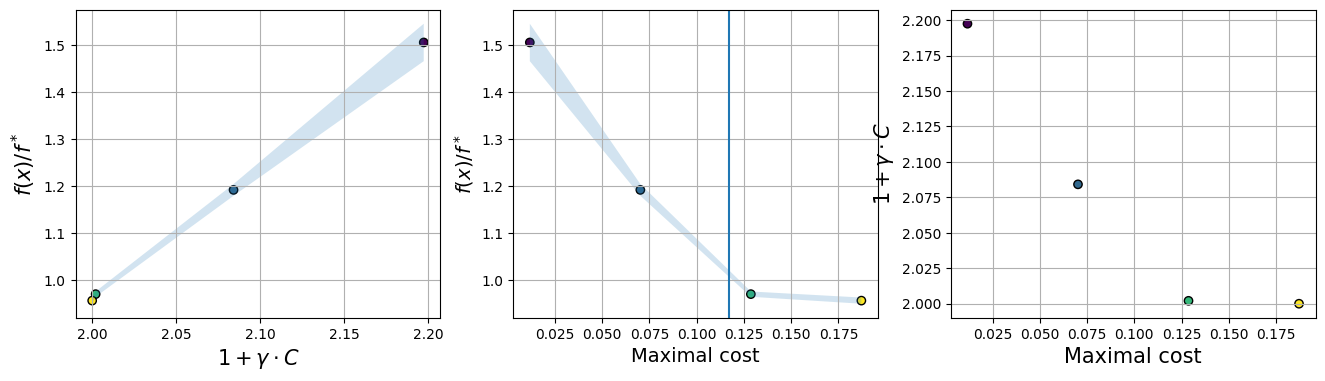

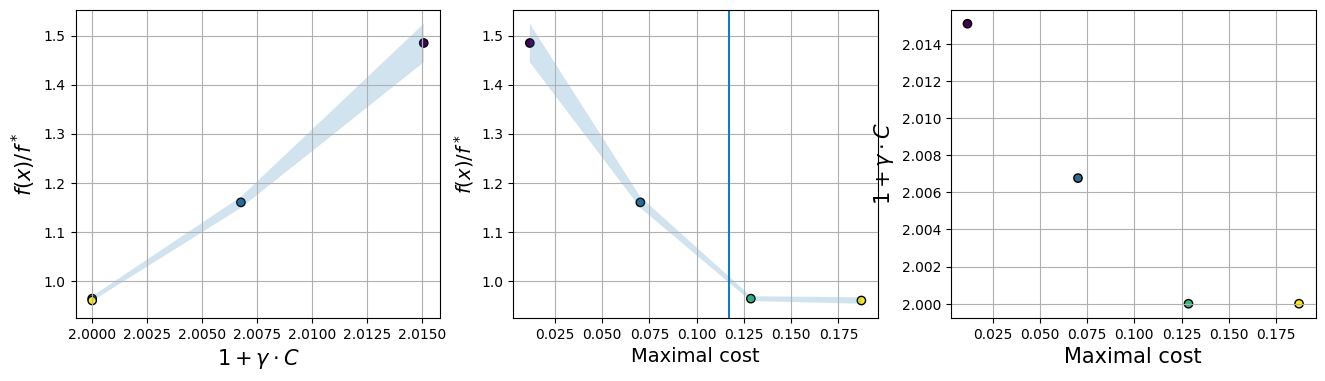

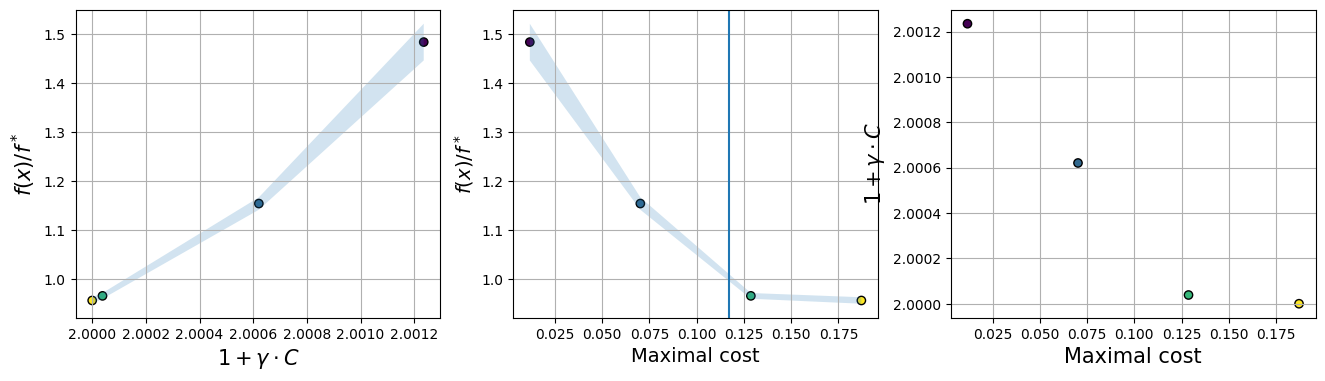

In [11]:
from paper_code.utils.drawer import plot_ratios

exp_ratios = []
for k, v in budget_norm_rez.items():
    print(k, type(v))
    budget_rez = v
    values = np.array([(r.value) for r in rezults])
    ratios = np.array([(r.values/values, r.values/values) for r in budget_rez]).T
    exp_ratios.append(ratios)
    ratios = np.array([ratios[:,0].mean(0), ratios[:,1].std(0)])
    print(ratios.shape)
    gammas = [1 + r.gamma for r in budget_rez]

    x1 = "Maximal cost"
    y1 = r"$f(x)/f^*$"
    l1 = r"$1 + \gamma \cdot C$"
    fig, ax = plot_ratios(ratios, gammas, budgets, x1,y1,l1, ratios_procecced=True)
    ax[1].axvline(x=np.mean(budgets_used))

exp_ratios = np.array(exp_ratios)[:,:,0]

(4, 3) (2, 4) (4,) (4,)
(4, 3) (2, 4) (4,) (4,)
(4, 3) (2, 4) (4,) (4,)


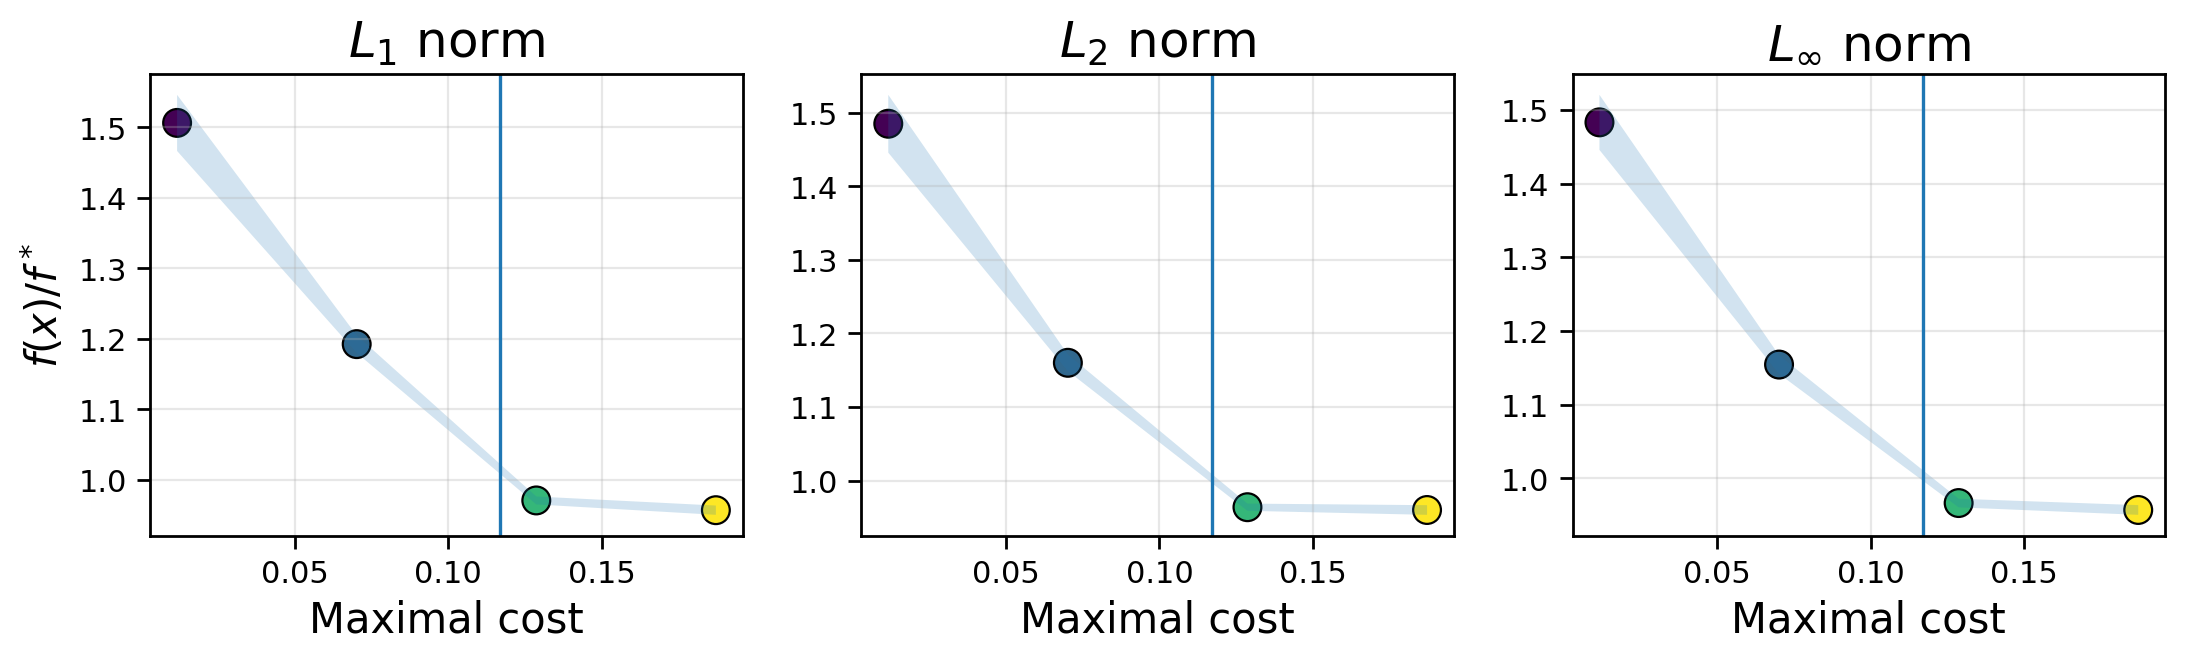

In [12]:
fig, ax = get_fig_set_style(None, (1,3), (13,3))
names = [r"$L_1$ norm",r"$L_2$ norm",r"$L_\infty$ norm"]
for i, rez in enumerate(exp_ratios):
    ratios = rez.T
    ratios_stat = np.array([(np.mean(r), np.std(r)) for r in ratios]).T
    colors = np.linspace(0, 2., len(ratios_stat[0]))
    print(ratios.shape, ratios_stat.shape, colors.shape, budgets.shape)

    ax[i].scatter(budgets , ratios_stat[0], c = colors, ec = 'k')
    ax[i].fill_between(budgets , ratios_stat[0] - ratios_stat[1], ratios_stat[0] + ratios_stat[1], alpha = 0.2)
    ax[i].grid(which="major", alpha=0.3)
    ax[i].set_title(names[i])
    ax[i].set_xlabel(x1)
    ax[i].ticklabel_format(axis="x", scilimits=[-3, 3])
    ax[i].axvline(x=np.mean(budgets_used))
ax[0].set_ylabel(y1)
plt.show()

Hint:
в монотонном случае добавляем штраф на используемый бюджет, тогда при достижении "насыщения" -- уголки пересекаются без штрафа, используется минимально возможный бюджет. Б

(3, 4)
[0.01169618 0.07017707 0.12865797 0.18713886] 0
[0.01169618 0.07017707 0.12865797 0.18713886] 1
[0.01169618 0.07017707 0.12865797 0.18713886] 2


Text(0.5, 0, 'Maximal cost')

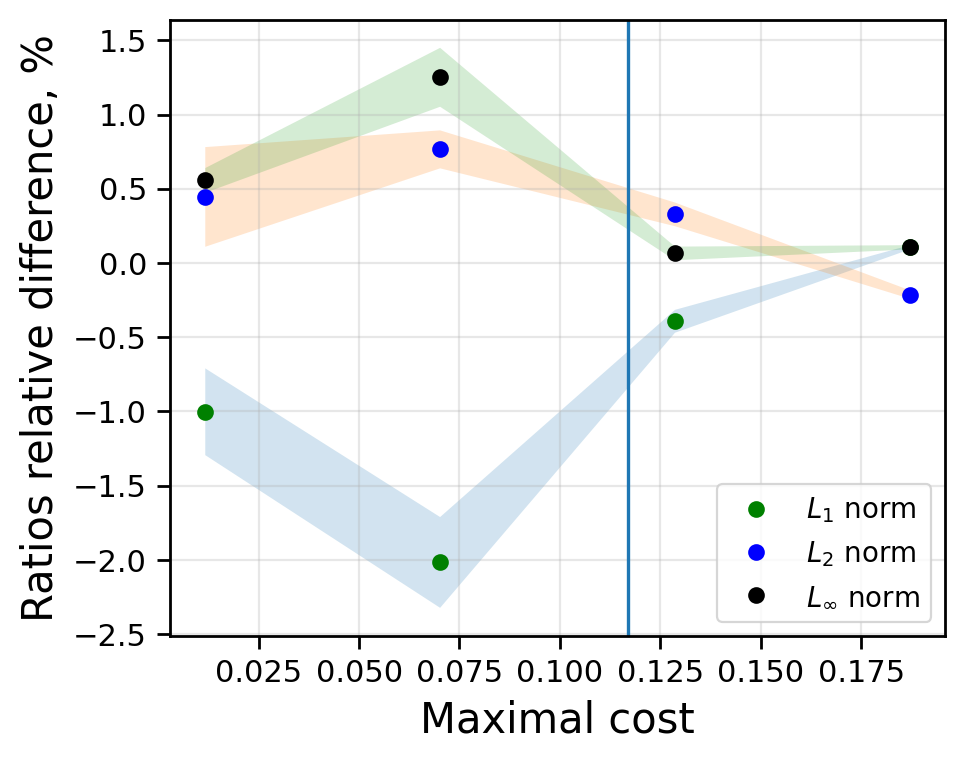

In [13]:
mmean = exp_ratios.mean(0)
print(mmean.shape)
colors = [ 'green', "blue", 'black']
names = [r"$L_1$ norm",r"$L_2$ norm",r"$L_\infty$ norm"]
fig, ax = get_fig_set_style(None, (1,1), (5,4))
# plt.figure(figsize = (5,4), dpi = 200)
ax.axvline(x=np.mean(budgets_used))
for i, r in enumerate(exp_ratios):
    ratios = r
    ratios_diff = ((mmean - ratios)/(mmean)).T
    ratios__diff_stat = np.array([(np.mean(r), np.std(r)) for r in ratios_diff]).T * 100
    # colors =  np.linspace(0, 2., len(max_budgets))
    # plt.scatter(max_budgets, (ratios_diff).mean(1), c = colors, ec = 'k')
    print(budgets, i)
    ax.plot(budgets, ratios__diff_stat[0], '.', color = colors[i], label = f"{names[i]}")
    ax.fill_between(budgets, ratios__diff_stat[0] - ratios__diff_stat[1], 
                    ratios__diff_stat[0] + ratios__diff_stat[1], alpha = 0.2)
ax.ticklabel_format(axis="x", scilimits=[-3, 3])
ax.grid(which="major", alpha=0.3)
ax.legend(loc="lower right")
ax.set_ylabel("Ratios relative difference, %", fontsize = 15)
ax.set_xlabel(x1, fontsize = 15)